# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.


In [1]:
# You may need to run this first- uncomment if so
#!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]

In [9]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [15]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [17]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [18]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

In [19]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

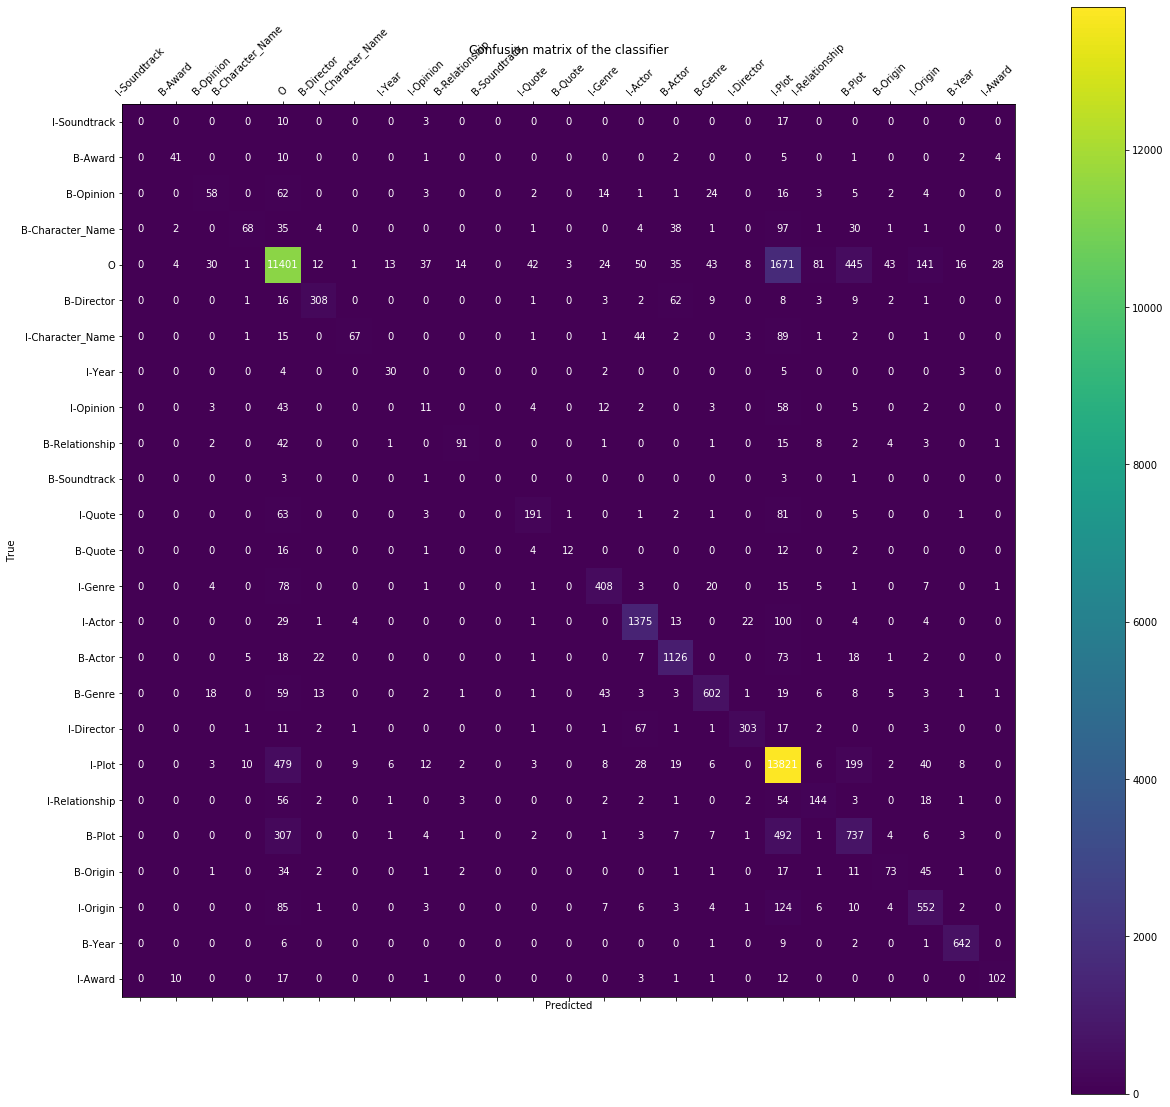

In [20]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [22]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [23]:
print_transition_weights(ct._tagger.info().transitions.items())

8.730936 B-Actor  -> I-Actor
8.345982 B-Plot   -> I-Plot
8.062881 B-Director -> I-Director
7.851024 B-Origin -> I-Origin
7.728286 I-Plot   -> I-Plot
7.557302 I-Quote  -> I-Quote
7.400516 B-Character_Name -> I-Character_Name
7.347592 I-Origin -> I-Origin
7.270472 B-Relationship -> I-Relationship
7.168646 B-Quote  -> I-Quote
7.019230 I-Relationship -> I-Relationship
6.874782 I-Soundtrack -> I-Soundtrack
6.792831 I-Opinion -> I-Opinion
6.739054 B-Genre  -> I-Genre
6.682199 B-Soundtrack -> I-Soundtrack
6.580473 B-Award  -> I-Award
6.441732 B-Opinion -> I-Opinion
6.428294 I-Award  -> I-Award
6.362482 I-Genre  -> I-Genre
6.348037 I-Actor  -> I-Actor
6.225893 I-Character_Name -> I-Character_Name
5.430455 I-Director -> I-Director
4.809019 I-Year   -> I-Year
4.082752 B-Year   -> I-Year
3.773733 B-Character_Name -> B-Plot
3.563915 O        -> O
3.562699 I-Character_Name -> B-Plot
3.277145 O        -> B-Plot
3.199695 B-Plot   -> B-Character_Name
3.091597 B-Opinion -> B-Genre
3.030532 O        -> 

In [24]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [25]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.191234 B-Year   HAS_NUM
4.378852 B-Genre  WORD_animated
4.376891 I-Year   WORD_s
3.280298 B-Genre  WORD_thriller
2.998992 B-Quote  WORD_i
2.986864 I-Genre  WORD_animated
2.968166 B-Genre  WORD_action
2.913375 B-Plot   WORD_a
2.910979 B-Opinion WORD_blockbuster
2.682290 B-Award  WORD_oscar
2.667863 B-Genre  WORD_animation
2.596255 B-Relationship SUF_uel
2.572959 B-Director WORD_disney
2.563763 B-Opinion WORD_masterpiece
2.552841 I-Genre  WORD_fiction
2.542230 B-Award  SUF_car
2.527780 B-Relationship WORD_remake
2.471652 B-Actor  WORD_cher
2.439679 B-Genre  WORD_horror
2.427487 I-Genre  WORD_white
2.413953 B-Relationship WORD_sequel
2.410295 I-Genre  WORD_thriller
2.378248 B-Genre  WORD_slasher
2.370675 B-Genre  WORD_comedy
2.337885 B-Origin WORD_adapted
2.304871 I-Actor  WORD_cage
2.276711 B-Genre  WORD_documentary
2.231418 B-Director SUF_xar
2.231418 B-Director WORD_pixar
2.227497 B-Genre  WORD_romance
2.184817 B-Genre  WORD_war
2.180846 B-Award  WORD_won
2.177721 B-Plot   WORD_an
2.

0.664553 B-Opinion WORD_super
0.664402 I-Actor  WORD_duvall
0.664186 B-Origin WORD_comic
0.664125 I-Opinion SUF_ece
0.663944 I-Plot   WORD_new
0.663638 B-Director SUF_att
0.663483 B-Relationship SUF_low
0.663472 B-Year   SUF_12
0.663120 B-Quote  WORD_open
0.663042 I-Actor  WORD_cable
0.662757 I-Plot   WORD_assassin
0.662507 B-Opinion SUF_art
0.662500 I-Plot   WORD_cia
0.662193 B-Character_Name SUF_eto
0.662193 B-Character_Name WORD_magneto
0.662163 I-Director SUF_ers
0.662146 B-Character_Name SUF_ky
0.662018 B-Plot   SUF_rom
0.661876 I-Actor  WORD_angelo
0.661803 B-Character_Name SUF_l
0.661742 I-Relationship SUF_ga
0.661557 I-Opinion WORD_made
0.661402 I-Plot   SUF_tor
0.661361 B-Actor  SUF_von
0.661038 I-Plot   WORD_iceberg
0.660923 I-Actor  WORD_lautner
0.660913 B-Actor  SUF_thy
0.660868 I-Plot   WORD_island
0.660729 B-Character_Name WORD_jerry
0.660685 B-Actor  WORD_nicholas
0.660507 B-Character_Name SUF_elo
0.660249 B-Quote  WORD_all
0.660179 B-Actor  WORD_louise
0.660030 I-Charac

0.475318 B-Character_Name WORD_lago
0.475265 I-Opinion WORD_the
0.475192 B-Character_Name WORD_mitch
0.475153 I-Plot   WORD_escaping
0.475100 B-Quote  WORD_mawwage
0.475058 I-Character_Name SUF_nos
0.475058 I-Character_Name WORD_wuornos
0.475023 I-Soundtrack WORD_bonnet
0.475020 B-Opinion SUF_ell
0.475001 B-Character_Name WORD_guenevere
0.474902 I-Genre  SUF_i
0.474877 B-Opinion WORD_self
0.474874 I-Quote  WORD_reprises
0.474863 B-Genre  WORD_fanciful
0.474830 I-Plot   WORD_dagger
0.474813 B-Genre  WORD_murder
0.474787 B-Opinion WORD_delighting
0.474755 B-Actor  WORD_dakota
0.474749 B-Actor  SUF_yi
0.474726 I-Character_Name WORD_mr
0.474714 B-Quote  WORD_tawanda
0.474703 I-Opinion WORD_generations
0.474655 I-Plot   SUF_cal
0.474646 B-Character_Name WORD_scout
0.474606 B-Genre  WORD_tragic
0.474528 I-Plot   WORD_dog
0.474514 I-Year   WORD_eighties
0.474460 I-Plot   WORD_insurance
0.474425 B-Plot   WORD_you
0.474406 B-Plot   SUF_ien
0.474397 B-Plot   WORD_themsleves
0.474367 B-Soundtrack

0.389798 B-Director WORD_sylvester
0.389793 B-Award  SUF_o
0.389718 B-Genre  SUF_pse
0.389656 I-Relationship WORD_were
0.389597 I-Character_Name WORD_say
0.389583 I-Plot   WORD_protecting
0.389527 I-Quote  WORD_been
0.389525 B-Opinion WORD_perennial
0.389522 B-Character_Name WORD_lenny
0.389503 I-Character_Name SUF_int
0.389442 I-Plot   WORD_faced
0.389332 I-Character_Name SUF_ynn
0.389258 B-Opinion SUF_ox
0.389245 I-Origin SUF_ved
0.389245 I-Director WORD_apted
0.389215 I-Award  WORD_10
0.389182 I-Origin WORD_spaceship
0.389108 B-Director WORD_philip
0.389070 B-Character_Name WORD_magento
0.389057 B-Actor  SUF_x
0.388994 B-Character_Name SUF_get
0.388983 B-Plot   WORD_animated
0.388851 I-Plot   SUF_eir
0.388809 I-Origin WORD_fische
0.388745 B-Plot   WORD_switch
0.388675 I-Origin SUF_ks
0.388666 B-Director SUF_do
0.388577 I-Opinion SUF_ory
0.388496 I-Director SUF_ll
0.388482 B-Plot   SUF_rse
0.388450 I-Character_Name WORD_lundegaard
0.388436 I-Plot   SUF_ose
0.388329 B-Character_Name W

0.317206 I-Relationship WORD_end
0.317127 I-Origin SUF_aum
0.317127 I-Origin WORD_baum
0.317117 I-Director WORD_landis
0.317101 B-Plot   WORD_sing
0.317099 I-Plot   WORD_bring
0.317095 B-Character_Name SUF_gar
0.317073 I-Actor  WORD_mirren
0.317069 B-Soundtrack SUF_nal
0.317025 I-Plot   SUF_aho
0.317025 I-Plot   WORD_idaho
0.317016 I-Origin WORD_magee
0.316995 I-Origin WORD_mermaid
0.316930 B-Plot   WORD_members
0.316919 I-Relationship SUF_ddy
0.316869 B-Character_Name WORD_carl
0.316799 B-Character_Name SUF_ard
0.316771 B-Character_Name SUF_int
0.316669 B-Plot   WORD_mischievous
0.316595 I-Plot   WORD_drunk
0.316564 B-Quote  WORD_dead
0.316530 I-Character_Name SUF_ae
0.316530 I-Character_Name WORD_mae
0.316509 I-Actor  WORD_borgnine
0.316472 B-Director SUF_se
0.316456 B-Actor  SUF_om
0.316423 I-Genre  WORD_romantic
0.316349 I-Director WORD_camp
0.316339 I-Plot   SUF_pan
0.316339 I-Plot   WORD_japan
0.316291 B-Relationship SUF_can
0.316254 I-Plot   WORD_secrets
0.316248 I-Actor  SUF_vi

0.260767 I-Actor  WORD_macgregor
0.260742 I-Actor  SUF_sg
0.260742 I-Actor  SUF_rsg
0.260742 I-Actor  WORD_skarsg
0.260705 I-Quote  WORD_jack
0.260666 B-Genre  SUF_ree
0.260643 I-Character_Name WORD_trilogy
0.260589 I-Actor  WORD_beverly
0.260579 B-Director SUF_low
0.260512 I-Year   SUF_nd
0.260507 I-Quote  WORD_ruining
0.260477 B-Actor  WORD_telly
0.260476 B-Plot   WORD_genius
0.260472 I-Soundtrack SUF_eep
0.260459 I-Plot   WORD_cleaning
0.260392 B-Origin WORD_series
0.260383 I-Plot   WORD_concert
0.260374 I-Genre  SUF_boy
0.260334 I-Plot   SUF_ual
0.260334 I-Quote  WORD_weekend
0.260292 B-Plot   WORD_inbred
0.260237 I-Soundtrack SUF_rge
0.260204 I-Opinion WORD_adventure
0.260196 I-Character_Name SUF_zo
0.260176 I-Character_Name WORD_de
0.260139 B-Year   SUF_ent
0.260113 I-Actor  WORD_brothers
0.260093 I-Actor  WORD_raft
0.259923 B-Origin WORD_about
0.259908 I-Plot   WORD_polar
0.259813 I-Plot   WORD_sahara
0.259796 I-Origin WORD_writing
0.259783 I-Actor  WORD_savalas
0.259771 I-Plot 

0.190246 I-Actor  WORD_cazale
0.190217 B-Actor  SUF_odi
0.190217 B-Actor  WORD_jodi
0.190213 B-Plot   WORD_vehicles
0.190157 I-Character_Name WORD_head
0.190154 I-Actor  WORD_zac
0.190139 B-Plot   WORD_showed
0.190133 I-Plot   WORD_baking
0.190065 I-Character_Name WORD_luke
0.190061 I-Director SUF_bra
0.190018 B-Actor  WORD_brigitte
0.190016 B-Plot   WORD_twenty
0.189974 B-Plot   SUF_ect
0.189940 I-Director SUF_eu
0.189940 I-Director SUF_reu
0.189940 I-Director WORD_favreu
0.189920 I-Plot   WORD_driving
0.189855 I-Plot   WORD_enslaved
0.189777 I-Plot   WORD_astronaut
0.189700 I-Actor  WORD_auclair
0.189651 B-Plot   SUF_ap
0.189645 B-Opinion WORD_world
0.189643 B-Actor  SUF_esa
0.189634 I-Origin WORD_burroughs
0.189631 I-Plot   WORD_order
0.189565 I-Plot   WORD_descends
0.189548 B-Plot   SUF_vor
0.189441 I-Actor  WORD_butterfield
0.189427 I-Plot   WORD_14
0.189404 B-Director WORD_jorma
0.189392 B-Character_Name SUF_iny
0.189377 I-Genre  WORD_independent
0.189365 B-Actor  SUF_at
0.189360

0.108369 I-Plot   WORD_moralistic
0.108359 I-Plot   WORD_complicated
0.108346 I-Plot   WORD_far
0.108342 B-Year   SUF_36
0.108342 B-Year   SUF_936
0.108342 B-Year   WORD_1936
0.108313 I-Plot   WORD_farm
0.108234 I-Plot   WORD_agrees
0.108203 I-Plot   SUF_zzo
0.108112 I-Plot   WORD_abortion
0.108038 I-Actor  WORD_meryl
0.107966 I-Director WORD_levinson
0.107947 B-Origin SUF_am
0.107933 I-Origin WORD_cold
0.107909 I-Plot   SUF_ms
0.107880 I-Plot   WORD_poverty
0.107800 B-Actor  WORD_kim
0.107736 I-Plot   WORD_chimpanzees
0.107735 I-Origin WORD_bull
0.107685 I-Character_Name SUF_rk
0.107652 I-Relationship WORD_population
0.107602 B-Plot   WORD_accepts
0.107577 I-Quote  WORD_bad
0.107547 I-Origin SUF_rty
0.107516 I-Plot   WORD_monomaniacal
0.107492 I-Plot   WORD_fitzgerald
0.107473 B-Plot   SUF_ool
0.107443 I-Origin WORD_author
0.107401 I-Plot   WORD_genovia
0.107255 I-Plot   SUF_uyi
0.107255 I-Plot   WORD_puyi
0.107199 I-Plot   WORD_barbarians
0.107197 I-Plot   WORD_pay
0.107189 B-Plot   

0.058748 I-Plot   WORD_crowd
0.058746 I-Origin SUF_yce
0.058726 I-Plot   WORD_lease
0.058711 I-Plot   WORD_department
0.058701 I-Plot   WORD_ghostly
0.058700 I-Plot   WORD_advanced
0.058692 B-Plot   WORD_every
0.058647 B-Plot   SUF_uge
0.058642 B-Plot   WORD_tiny
0.058623 I-Plot   WORD_battles
0.058620 I-Plot   WORD_disrupted
0.058612 I-Plot   WORD_continuing
0.058600 I-Genre  SUF_pia
0.058597 I-Plot   WORD_treatment
0.058561 I-Plot   WORD_carbonite
0.058530 I-Plot   SUF_rim
0.058530 I-Plot   WORD_grim
0.058491 I-Origin WORD_tolkein
0.058433 B-Actor  SUF_ida
0.058426 I-Plot   WORD_avowed
0.058409 I-Plot   WORD_effort
0.058348 I-Plot   WORD_fashionable
0.058319 I-Actor  SUF_po
0.058319 I-Actor  SUF_rpo
0.058319 I-Actor  WORD_harpo
0.058231 I-Plot   WORD_decide
0.058224 I-Plot   WORD_fund
0.058208 I-Plot   WORD_nordic
0.058203 I-Actor  SUF_ney
0.058122 I-Plot   WORD_loudest
0.058113 B-Year   WORD_60
0.058016 I-Plot   WORD_distressed
0.057994 I-Plot   WORD_onset
0.057949 I-Character_Name 

0.010964 I-Plot   WORD_sum
0.010941 I-Plot   WORD_pours
0.010936 I-Plot   WORD_planets
0.010936 I-Plot   WORD_representative
0.010926 B-Plot   WORD_make
0.010902 I-Plot   WORD_godmother
0.010857 I-Plot   WORD_flailing
0.010832 I-Plot   WORD_encountering
0.010820 I-Plot   WORD_bury
0.010768 I-Plot   WORD_microscopic
0.010760 I-Plot   WORD_brain
0.010746 I-Plot   SUF_hag
0.010746 I-Plot   WORD_seahag
0.010741 I-Plot   WORD_wit
0.010736 I-Soundtrack SUF_ter
0.010727 I-Plot   WORD_whether
0.010713 I-Plot   SUF_ocy
0.010713 I-Plot   WORD_idiocy
0.010713 I-Plot   WORD_backgrounds
0.010709 I-Plot   WORD_investors
0.010706 I-Plot   WORD_footprints
0.010673 I-Plot   WORD_backdrop
0.010668 I-Plot   WORD_unexpected
0.010648 I-Plot   WORD_interferes
0.010619 I-Plot   SUF_ngs
0.010607 I-Origin SUF_nth
0.010585 I-Plot   WORD_sacrificed
0.010577 I-Plot   WORD_overland
0.010554 I-Genre  SUF_gic
0.010534 I-Plot   WORD_uncovering
0.010497 I-Plot   WORD_sharing
0.010493 I-Plot   WORD_exposition
0.010492 

-0.110738 I-Actor  WORD_orson
-0.110881 B-Character_Name SUF_od
-0.110953 I-Plot   SUF_nap
-0.110953 I-Plot   WORD_kidnap
-0.111021 I-Director SUF_ill
-0.111229 I-Plot   WORD_psychic
-0.111306 B-Plot   SUF_hor
-0.111969 B-Character_Name SUF_ht
-0.111969 B-Character_Name SUF_ght
-0.112052 I-Genre  WORD_in
-0.112243 I-Plot   WORD_showcases
-0.112305 I-Origin SUF_nn
-0.112412 I-Relationship SUF_od
-0.112711 I-Origin WORD_year
-0.112830 B-Opinion WORD_and
-0.112976 B-Plot   WORD_follow
-0.113020 I-Origin SUF_ess
-0.113054 I-Origin WORD_telling
-0.113120 I-Plot   WORD_seek
-0.113368 I-Plot   WORD_appear
-0.113418 I-Plot   SUF_exy
-0.113418 I-Plot   WORD_sexy
-0.113446 I-Opinion SUF_lms
-0.113522 I-Plot   WORD_gathering
-0.113523 I-Plot   SUF_med
-0.113556 I-Plot   SUF_aft
-0.113568 I-Plot   WORD_river
-0.113874 I-Plot   WORD_success
-0.113877 B-Plot   WORD_little
-0.113904 I-Plot   WORD_adaptation
-0.114183 I-Plot   WORD_civil
-0.114330 B-Quote  SUF_ey
-0.114432 B-Actor  SUF_ver
-0.114598 I

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [26]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [29]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [30]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge